In [ ]:
import scipy as sp
from PIL import Image as im
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters
from skimage.filters import threshold_otsu, threshold_local

path="RLD.jpeg"

#converts image to boolean with thresholding
image=skimage.io.imread(path)
gray_image = skimage.color.rgb2gray(image)
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        gray_image[i][j]=int(gray_image[i][j]*255)
gi = np.empty(gray_image.shape,np.uint8)
for i in range(gray_image.shape[0]):
    for j in range(gray_image.shape[1]):
        gi[i][j]=(gray_image[i][j])
local_thresh = threshold_local(gi, 35, offset=10)
img = gi > local_thresh

#finds number of black points
pix = np.array(img)
ctr = 0
for i in range(pix.shape[0]):
    for j in range(pix.shape[1]):
        if(pix[i][j]==False):
            ctr=ctr+1

#finds coordinates of black points
x=[]
y=[]
for i in range(pix.shape[0]):
    for j in range(pix.shape[1]):        
        if(pix[i][j]==False):
            y.append(pix.shape[0]-i)
            x.append(j)

#cuts down to terms with unique x value
x_uniq=np.unique(x)
y_temp=[]
for i in range(x_uniq.shape[0]):
    s=0
    freq=0
    for j in range(ctr):
        if(x[j]==x_uniq[i]):
            s=s+y[j]
            freq=freq+1
    y_temp.append(int(s/freq))
y_uniq=np.array(y_temp)

#creates polynomial model
coeff=np.polyfit(x,y,10)
curve=np.poly1d(coeff)
line=np.linspace(x_uniq[0],x_uniq[x_uniq.shape[0]-1],1000)

#displays in a plot
im = plt.imread(path)
fig=plt.figure(dpi=100,figsize=(5,5))
plt.scatter(x_uniq,y_uniq, s=1, marker='.',color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot')
plt.axis([0,pix.shape[1],0,pix.shape[0]])
#plt.grid()
plt.imshow(im, extent=[0, pix.shape[1], 0, pix.shape[0]])
plt.plot(line, curve(line), color='r')
plt.show()
fig.savefig("Curve Fit",transparent=False,dpi=1000)
print(gi)

In [ ]:
import scipy as sp
from PIL import Image as im
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.color
import skimage.filters
from skimage import exposure
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local
from skimage.feature import canny
from skimage.filters import sobel
from skimage.exposure import histogram

path="Pic\F (10).jpg"

#converts to grayscale
image=skimage.io.imread(path)
gray_image = skimage.color.rgb2gray(image)
gray_image = skimage.img_as_ubyte(gray_image)

#finds elevation map and rescales
elevation_map=sobel(gray_image)
p2, p98 = np.percentile(elevation_map, (2, 98))
img_rescale = exposure.rescale_intensity(elevation_map, in_range=(p2, p98))
img_hc = skimage.img_as_ubyte(img_rescale)
img_hc = np.subtract(255,img_hc)


#thresholds and convert to byte
img_t = img_hc > 1
img_t=skimage.img_as_ubyte(img_t)

#removes noise and converts to boolean
img_dn=skimage.morphology.area_closing(img_t,area_threshold=5000,connectivity=1)
img_dn=skimage.img_as_bool(img_dn)

#crop image
y1,y2=0,0
x1,x2=0,0
for i in range(img_dn.shape[1]):
    arr=[]
    flag = False
    for j in range(img_dn.shape[0]):
        if(not img_dn[j][i]):
            arr.append(j)
            flag=True
    if(flag):
        y1=int(sum(arr)/len(arr))
        x1=i
        break
for i in range(img_dn.shape[1]-1,0,-1):
    arr=[]
    flag = False
    for j in range(img_dn.shape[0]):
        if(not img_dn[j][i]):
            arr.append(j)
            flag=True
    if(flag):
        y2=int(sum(arr)/len(arr))
        x2=i
        break
y_c=int((y1+y2)/2)
img=img_dn[0:y_c,0:img_dn.shape[1]]

#finds number of black points
pix = np.array(img)
# ctr = 0
# for i in range(pix.shape[0]):
#     for j in range(pix.shape[1]):
#         if(pix[i][j]==False):
#             ctr=ctr+1

#finds coordinates of black points
x=[]
y=[]
for i in range(pix.shape[0]):
    for j in range(pix.shape[1]):        
        if(pix[i][j]==False):
            y.append(pix.shape[0]-i)
            x.append(j)

#cuts down to terms with unique x value
# x_uniq=np.unique(x)
# y_temp=[]
# for i in range(x_uniq.shape[0]):
#     s=0
#     freq=0
#     for j in range(ctr):
#         if(x[j]==x_uniq[i]):
#             y_temp.append(y[j])
#             break
# y_uniq=np.array(y_temp)


#creates polynomial model
coeff=np.polyfit(x,y,10)
curve=np.poly1d(coeff)
line=np.linspace(min(x),max(x),1000)

#slopes and angles of contact
diff=np.poly1d(np.polyder(coeff,m=1))
while np.poly1d(np.polyder(coeff,m=2))(x1) > 0:
    x1=x1+1
while np.poly1d(np.polyder(coeff,m=2))(x2) > 0:
    x2=x2-1
slopes=[diff(x1),diff(x2)]
angle_of_contact_rad=np.arctan(np.abs(slopes))
angle_of_contact_deg=angle_of_contact_rad*180/np.pi

#tangents
tan_1=np.poly1d([slopes[0],curve(x1)-x1*slopes[0]])
line_1=np.linspace(x1-200,x1+200,1000)
tan_2=np.poly1d([slopes[1],curve(x2)-x2*slopes[1]])
line_2=np.linspace(x2-200,x2+200,1000)

#displays in a plot
im = plt.imread(path)
fig=plt.figure(dpi=100,figsize=(5,5))
#plt.scatter(x_uniq,y_uniq, s=0.01, marker='.',color='g')
plt.title('Contact Angles are ' + str(round(angle_of_contact_deg[0],2)) + ' & ' + str(round(angle_of_contact_deg[1],2)), backgroundcolor='white')
plt.axis([0,pix.shape[1],y_c-im.shape[0],pix.shape[0]])
plt.axis('off')
#plt.grid()
plt.imshow(im, extent=[0,im.shape[1], y_c-im.shape[0],y_c])
plt.plot(line, curve(line), color='r', linewidth=0.5)
plt.plot(line_1, tan_1(line_1), color='blue', linewidth=1)
plt.plot(line_2, tan_2(line_2), color='blue', linewidth=1)
#plt.scatter([x1,x2],[curve(x1),curve(x2)], s=1, marker='.',color='g')#---
plt.show()
fig.savefig("Curve Fit 10test",transparent=False,dpi=1000)

#skimage.io.imshow(im)
#skimage.io.imsave(fname="Processed_F3_dn.jpg",arr=img_dn)
#skimage.io.imsave(fname="Processed_F3_cr.jpg",arr=img)


#------------------------------------------------------------------------------------------------------------------------------#
 

In [ ]:
#finds number of black points
pix = np.array(img)
ctr = 0
for i in range(pix.shape[0]):
    for j in range(pix.shape[1]):
        if(pix[i][j]==False):
            ctr=ctr+1

#finds coordinates of black points
x=[]
y=[]
for i in range(pix.shape[0]):
    for j in range(pix.shape[1]):        
        if(pix[i][j]==False):
            y.append(pix.shape[0]-i)
            x.append(j)

#cuts down to terms with unique x value
# x_uniq=np.unique(x)
# y_temp=[]
# for i in range(x_uniq.shape[0]):
#     s=0
#     freq=0
#     for j in range(ctr):
#         if(x[j]==x_uniq[i]):
#             s=s+y[j]
#             freq=freq+1
#     y_temp.append(int(s/freq))
# y_uniq=np.array(y_temp)

#creates polynomial model
coeff=np.polyfit(x,y,50)
curve=np.poly1d(coeff)
line=np.linspace(x_uniq[0],x_uniq[x_uniq.shape[0]-1],1000)

#displays in a plot
im = plt.imread(path)
fig=plt.figure(dpi=100,figsize=(5,5))
plt.scatter(x_uniq,y_uniq, s=1, marker='.',color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot')
plt.axis([0,pix.shape[1],0,pix.shape[0]])
#plt.grid()
plt.imshow(im, extent=[0, img_dn.shape[1], 0, img_dn.shape[0]])
plt.plot(line, curve(line), color='r')
plt.show()
fig.savefig("Curve Fit",transparent=False,dpi=1000)

In [ ]:
import scipy as sp
from PIL import Image as im
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.color
import skimage.filters
from skimage import exposure
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local
from skimage.feature import canny
from skimage.filters import sobel
from skimage.exposure import histogram

def contact_angle(path, dest_file):

    #converts to grayscale
    image=skimage.io.imread(path)
    gray_image = skimage.color.rgb2gray(image)
    gray_image = skimage.img_as_ubyte(gray_image)

    #finds elevation map and rescales
    elevation_map=sobel(gray_image)
    p2, p98 = np.percentile(elevation_map, (2, 98))
    img_rescale = exposure.rescale_intensity(elevation_map, in_range=(p2, p98))
    img_hc = skimage.img_as_ubyte(img_rescale)
    img_hc = np.subtract(255,img_hc)


    #thresholds and convert to byte
    img_t = img_hc > 1
    img_t=skimage.img_as_ubyte(img_t)

    #removes noise and converts to boolean
    img_dn=skimage.morphology.area_closing(img_t,area_threshold=5000,connectivity=1)
    img_dn=skimage.img_as_bool(img_dn)

    #crop image
    y1,y2=0,0
    x1,x2=0,0
    for i in range(img_dn.shape[1]):
        arr=[]
        flag = False
        for j in range(img_dn.shape[0]):
            if(not img_dn[j][i]):
                arr.append(j)
                flag=True
        if(flag):
            y1=int(sum(arr)/len(arr))
            x1=i
            break
    for i in range(img_dn.shape[1]-1,0,-1):
        arr=[]
        flag = False
        for j in range(img_dn.shape[0]):
            if(not img_dn[j][i]):
                arr.append(j)
                flag=True
        if(flag):
            y2=int(sum(arr)/len(arr))
            x2=i
            break
    y_c=int((y1+y2)/2)
    y_c=y1#-------------
    img_c=img_dn[0:y_c,0:img_dn.shape[1]]

    #fill small holes
    img_c_i=np.empty(img_c.shape, dtype=np.int8)
    for i in range(img_c.shape[0]):
        for j in range(img_c.shape[1]):
            if(not img_c[i][j]):
                img_c_i[i][j]=1
            else:
                img_c_i[i][j]=0
    img=sp.ndimage.binary_fill_holes(img_c_i)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j]=not img[i][j]


    #finds coordinates of black points
    pix = np.array(img)
    x=[]
    y=[]
    for j in range(int(pix.shape[1]/2),pix.shape[1]):
        if(pix[pix.shape[0]-1][j]==False):
            break
        for i in reversed(range(pix.shape[0])):        
            if(pix[i][j]==False):
                y.append(pix.shape[0]-i)
                x.append(j)
                break
    for j in reversed(range(int(pix.shape[1]/2))):
        if(pix[pix.shape[0]-1][j]==False):
            break
        for i in reversed(range(pix.shape[0])):        
            if(pix[i][j]==False):
                y.append(pix.shape[0]-i)
                x.append(j)
                break


    #creates polynomial model
    coeff=np.polyfit(x,y,90)
    curve=np.poly1d(coeff)
    line=np.linspace(min(x),max(x),1000)

    #slopes and angles of contact
    diff=np.poly1d(np.polyder(coeff,m=1))
    slopes=[diff(min(x)),diff(max(x))]
    angle_of_contact_rad=np.arctan(np.abs(slopes))
    angle_of_contact_deg=angle_of_contact_rad*180/np.pi

    #tangents
    x_l1=0
    for i in range(img.shape[1]):
        if(not img[img.shape[0]-1][i]):
            x_l1=i
            break
    tan_1=np.poly1d([slopes[0],-x_l1*slopes[0]])
    line_1=np.linspace(x_l1,x_l1+50,1000)
    x_l2=0
    for i in reversed(range(img.shape[1])):
        if(not img[img.shape[0]-1][i]):
            x_l2=i
            break
    tan_2=np.poly1d([slopes[1],-x_l2*slopes[1]])
    line_2=np.linspace(x_l2-50,x_l2,1000)

    #displays in a plot
    im = plt.imread(path)
    fig=plt.figure(dpi=100,figsize=(5,5))
    plt.title('Contact Angles are ' + str(round(angle_of_contact_deg[0],2)) + ' & ' + str(round(angle_of_contact_deg[1],2)), backgroundcolor='white')
    plt.axis([0,pix.shape[1],y_c-im.shape[0],pix.shape[0]])
    plt.axis('off')
    #plt.grid()
    plt.imshow(im, extent=[0,im.shape[1], y_c-im.shape[0],y_c])
    plt.plot(line, curve(line), color='r', linewidth=0.5)
    plt.plot(line_1, tan_1(line_1), color='blue', linewidth=1)
    plt.plot(line_2, tan_2(line_2), color='blue', linewidth=1)
    plt.scatter(x,y, s=0.01, marker=',',color='g')
    #plt.scatter([x1,x2],[curve(x1),curve(x2)], s=1, marker='.',color='g')#---
    #plt.show()
    fig.savefig(dest_file,transparent=False,dpi=1000)

#     skimage.io.imshow(im)
#     skimage.io.imsave(fname="Processed_F_dn.png",arr=img_dn)
#     skimage.io.imsave(fname="Processed_F_cr.png",arr=img_c)
#     skimage.io.imsave(fname="Processed_F_fh.png",arr=img)


    #------------------------------------------------------------------------------------------------------------------------------#
import os

files = [f for f in os.listdir('.') if os.path.isfile(f)]
ctr=0
for f in files:
    if f.endswith('.jpg'):
        contact_angle(f, f.split('.')[0]+"_Processed.png")
        ctr=ctr+1
        print(str(ctr)+' done!')

1 done!
2 done!
3 done!
4 done!
5 done!
6 done!
7 done!
8 done!
9 done!
10 done!
11 done!
12 done!
13 done!


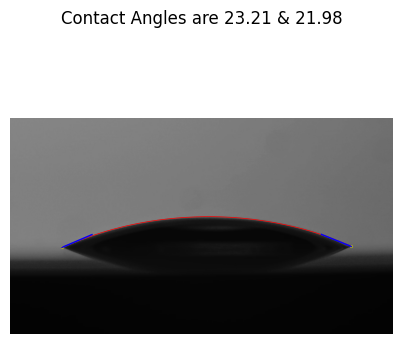

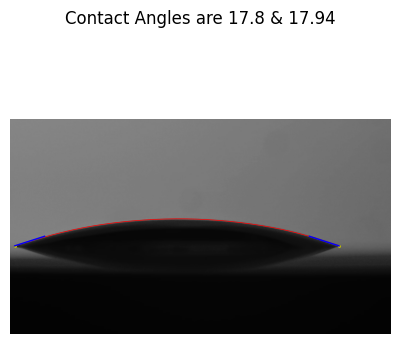

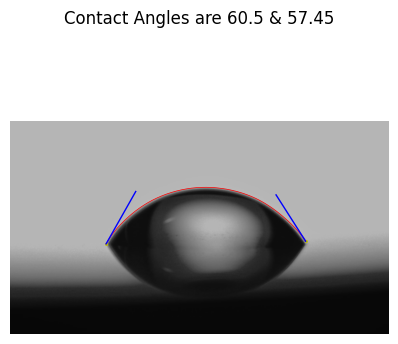

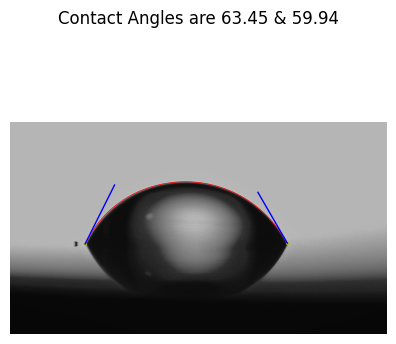

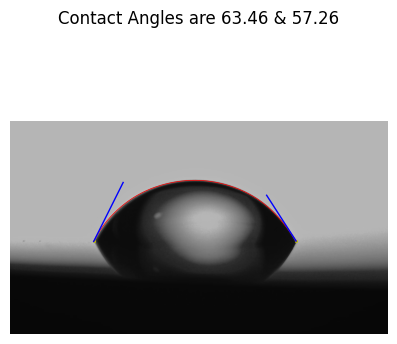

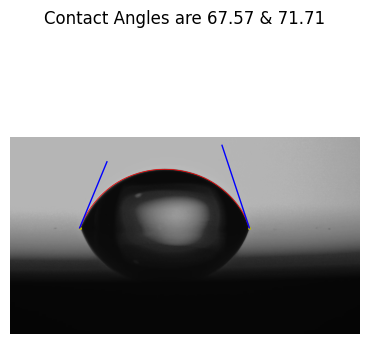

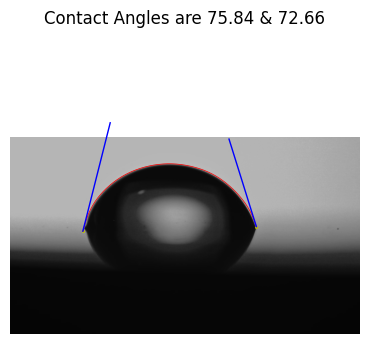

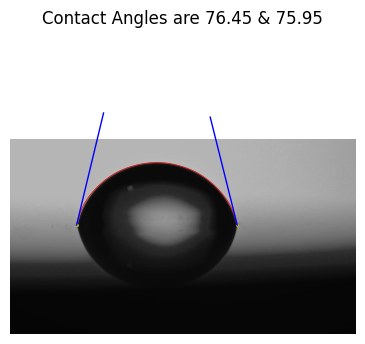

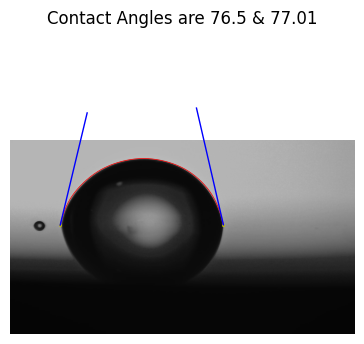

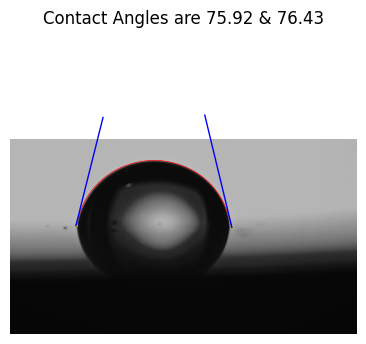

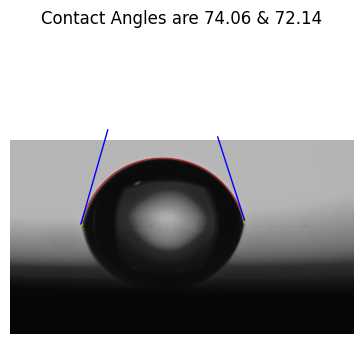

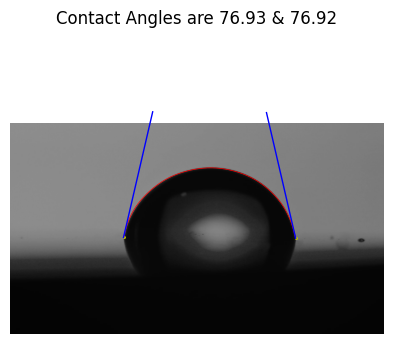

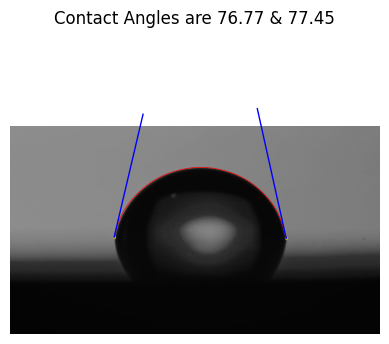

In [1]:
import scipy as sp
from PIL import Image as im
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.color
import skimage.filters
from skimage import exposure
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local
from skimage.feature import canny
from skimage.filters import sobel
from skimage.exposure import histogram

# path="S7_DST degrease_100C_0 hrs_2.jpg"
# dest_file="T1.png"

def contact_angle(path, dest_file):
    #converts to grayscale
    image=skimage.io.imread(path)
    gray_image = skimage.color.rgb2gray(image)
    gray_image = skimage.img_as_ubyte(gray_image)

    #finds elevation map and rescales
    elevation_map=sobel(gray_image)
    p2, p98 = np.percentile(elevation_map, (2, 98))
    img_rescale = exposure.rescale_intensity(elevation_map, in_range=(p2, p98))
    img_hc = skimage.img_as_ubyte(img_rescale)
    img_hc = np.subtract(255,img_hc)


    #thresholds and convert to byte
    img_t = img_hc > 1
    img_t=skimage.img_as_ubyte(img_t)

    #removes noise and converts to boolean
    img_dn=skimage.morphology.area_closing(img_t,area_threshold=5000,connectivity=1)
    img_dn=skimage.img_as_bool(img_dn)

    #crop image
    y1,y2=0,0
    x1,x2=0,0
    for i in range(img_dn.shape[1]):
        arr=[]
        flag = False
        for j in range(img_dn.shape[0]):
            if(not img_dn[j][i]):
                arr.append(j)
                flag=True
        if(flag):
            y1=int(sum(arr)/len(arr))
            x1=i
            break
    for i in range(img_dn.shape[1]-1,0,-1):
        arr=[]
        flag = False
        for j in range(img_dn.shape[0]):
            if(not img_dn[j][i]):
                arr.append(j)
                flag=True
        if(flag):
            y2=int(sum(arr)/len(arr))
            x2=i
            break
    y_c=int((y1+y2)/2)
    y_c=y1#-------------
    img_c=img_dn[0:y_c,0:img_dn.shape[1]]

    #fill small holes
    img_c_i=np.empty(img_c.shape, dtype=np.int8)
    for i in range(img_c.shape[0]):
        for j in range(img_c.shape[1]):
            if(not img_c[i][j]):
                img_c_i[i][j]=1
            else:
                img_c_i[i][j]=0
    img_fh=sp.ndimage.binary_fill_holes(img_c_i)

    #run binary erosion
    img=skimage.morphology.binary_erosion(img_fh)
    img=skimage.morphology.binary_erosion(img)
    img=skimage.morphology.binary_erosion(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j]=not img[i][j]

    #finds coordinates of black points
    x=[]
    y=[]
    for j in range(int(img.shape[1]/2),img.shape[1]):
        for i in (range(img.shape[0])):#rev
            if(img[i][j]==False):
                y.append(img.shape[0]-i)
                x.append(j)
                break
    for j in reversed(range(int(img.shape[1]/2))):
        for i in (range(img.shape[0])):#rev   
            if(img[i][j]==False):
                y.append(img.shape[0]-i)
                x.append(j)
                break

    #creates polynomial model
    coeff=np.polyfit(x,y,10)
    curve=np.poly1d(coeff)
    line=np.linspace(min(x),max(x),1000)
    
    #slopes and angles of contact
    x1,x2=min(x),max(x)
    diff=np.poly1d(np.polyder(coeff,m=1))
    slopes=[diff(x1),diff(x2)]
    angle_of_contact_rad=np.arctan(np.abs(slopes))
    angle_of_contact_deg=angle_of_contact_rad*180/np.pi

    #tangents
    tan_1=np.poly1d([slopes[0],curve(x1)-x1*slopes[0]])
    line_1=np.linspace(x1,x1+200,1000)
    tan_2=np.poly1d([slopes[1],curve(x2)-x2*slopes[1]])
    line_2=np.linspace(x2-200,x2,1000)

    #displays in a plot
    im = plt.imread(path)
    #im=img
    fig=plt.figure(dpi=100)#,figsize=(5,5)
    plt.title('Contact Angles are ' + str(round(angle_of_contact_deg[0],2)) + ' & ' + str(round(angle_of_contact_deg[1],2)), backgroundcolor='white')
    plt.axis([0,img.shape[1],y_c-im.shape[0],im.shape[0]])
    plt.axis('off')
    #plt.grid()
    plt.imshow(im, extent=[0,im.shape[1], y_c-im.shape[0],y_c])
    #plt.imshow(im, extent=[0,im.shape[1], 0,im.shape[0]])
    plt.plot(line, curve(line), color='r', linewidth=0.5)
    plt.plot(line_1, tan_1(line_1), color='blue', linewidth=1)
    plt.plot(line_2, tan_2(line_2), color='blue', linewidth=1)
    #plt.scatter(x,y, s=0.01, marker='.',color='g')
    plt.scatter([min(x),max(x)],[curve(min(x)),curve(max(x))], s=5, marker='.',color='y')#---
    #plt.show()
    fig.savefig(dest_file,transparent=False,dpi=1000)

    #skimage.io.imshow(img)
#     skimage.io.imsave(fname="Processed_F_dn.png",arr=img_dn)
#     skimage.io.imsave(fname="Processed_F_cr.png",arr=img_c)
#     skimage.io.imsave(fname="Processed_F_fh.png",arr=img_fh)
#     skimage.io.imsave(fname="Processed_F_er.png",arr=img)

import os

files = [f for f in os.listdir('.') if os.path.isfile(f)]
ctr=0
for f in files:
    if f.endswith('.jpg'):
        contact_angle(f, f.split('.')[0]+"_Processed.png")
        ctr=ctr+1
        print(str(ctr)+' done!')

In [4]:
#finds coordinates of black points
pix = np.array(img)
x=[]
y=[]
for j in range(int(pix.shape[1]/2),pix.shape[1]):
    if(pix[pix.shape[0]-1][j]==False):
        break
    for i in (range(pix.shape[0])):#rev
        if(pix[i][j]==False):
            y.append(pix.shape[0]-i)
            x.append(j)
            break
for j in reversed(range(int(pix.shape[1]/2))):
    if(pix[pix.shape[0]-1][j]==False):
        break
    for i in (range(pix.shape[0])):#rev   
        if(pix[i][j]==False):
            y.append(pix.shape[0]-i)
            x.append(j)
            break

#Linear regression for tangents
no=200
min_x,max_x=min(x),max(x)
t1_x,t1_y=[],[]
for i in range(len(x)):
    if(x[i]<=min_x+no):
        t1_x.append(x[i])
        t1_y.append(y[i])
t1=np.polyfit(t1_x,t1_y,1)
t2_x,t2_y=[],[]
for i in range(len(x)):
    if(x[i]>=max_x-no):
        t2_x.append(x[i])
        t2_y.append(y[i])
t2=np.polyfit(t2_x,t2_y,1)
slopes=[t1[0],t2[0]]
angle_of_contact_rad=np.arctan(np.abs(slopes))
angle_of_contact_deg=angle_of_contact_rad*180/np.pi

#tangents
x_l1=0
for i in range(img.shape[1]):
    if(not img[img.shape[0]-1][i]):
        x_l1=i
        break
tan_1=np.poly1d([slopes[0],-x_l1*slopes[0]])
line_1=np.linspace(x_l1,x_l1+50,1000)
x_l2=0
for i in reversed(range(img.shape[1])):
    if(not img[img.shape[0]-1][i]):
        x_l2=i
        break
tan_2=np.poly1d([slopes[1],-x_l2*slopes[1]])
line_2=np.linspace(x_l2-50,x_l2,1000)

#creates polynomial model
coeff=np.polyfit(x,y,50)
curve=np.poly1d(coeff)
line=np.linspace(min(x)-200,max(x)+200,1000)#-----



#displays in a plot
im = plt.imread(path)
fig=plt.figure(dpi=100,figsize=(5,5))
plt.title('Contact Angles are ' + str(round(angle_of_contact_deg[0],2)) + ' & ' + str(round(angle_of_contact_deg[1],2)), backgroundcolor='white')
plt.axis([0,pix.shape[1],y_c-im.shape[0],pix.shape[0]])
plt.axis('off')
#plt.grid()
plt.imshow(im, extent=[0,im.shape[1], y_c-im.shape[0],y_c])
plt.plot(line, curve(line), color='r', linewidth=0.5)
#plt.plot(line_1, tan_1(line_1), color='blue', linewidth=1)
#plt.plot(line_2, tan_2(line_2), color='blue', linewidth=1)
plt.scatter(t1_x,t1_y, s=0.01, marker='.',color='g')
plt.scatter(t2_x,t2_y, s=0.01, marker='.',color='g')
#plt.scatter([min(x),max(x)],[curve(min(x)),curve(max(x))], s=5, marker='.',color='y')#---
#plt.show()
fig.savefig(dest_file,transparent=False,dpi=1000)


#------------------------------------------------------------------------------------------------------------------------------#

# #slopes and angles of contact
# diff=np.poly1d(np.polyder(coeff,m=1))
# slopes=[diff(min(x)),diff(max(x))]
# angle_of_contact_rad=np.arctan(np.abs(slopes))
# angle_of_contact_deg=angle_of_contact_rad*180/np.pi

# #tangents
# x_l1=0
# for i in range(img.shape[1]):
#     if(not img[img.shape[0]-1][i]):
#         x_l1=i
#         break
# tan_1=np.poly1d([slopes[0],-x_l1*slopes[0]])
# line_1=np.linspace(x_l1,x_l1+50,1000)
# x_l2=0
# for i in reversed(range(img.shape[1])):
#     if(not img[img.shape[0]-1][i]):
#         x_l2=i
#         break
# tan_2=np.poly1d([slopes[1],-x_l2*slopes[1]])
# line_2=np.linspace(x_l2-50,x_l2,1000)

NameError: name 'img' is not defined

In [10]:
import statistics

act=[24.07,23.12,19.51,19.49,60.6,61.84,60.15,61.74,60.6,61.84,67.64,70.87,72.41,71.83,76.44,76.28,79.6,80.75,82.1,83.43,76.08,79.89,79.88,80.49,80.07,80.06]
my=[23.21,21.98,17.8,17.94,60.5,57.45,63.45,59.94,63.46,57.26,67.57,71.71,75.84,72.66,76.45,75.95,76.5,77.01,75.92,76.43,74.06,72.14,76.93,76.92,76.77,77.45]
diff=np.subtract(my,act)
mean=sum(diff)/len(diff)
sd=statistics.stdev(diff)
print(mean)
print(sd)

-1.826153846153845
2.902301261996179
